# Table of Contents
* [Submitting HITs](#Submitting-HITs)
	* [Building URLs for images on s3](#Building-URLs-for-images-on-s3)
	* [submitting HITs in groups](#submitting-HITs-in-groups)
* [Reviewing HITs](#Reviewing-HITs)
	* [Looking at worker breakdown](#Looking-at-worker-breakdown)
* [HIT end-of-life](#HIT-end-of-life)
	* [Pickle Results for temp storage](#Pickle-Results-for-temp-storage)
	* [Careful with these](#Careful-with-these)


In [259]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

In [323]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light default
plt.rcParams['figure.figsize'] = (16.0, 10.0)

In [230]:
import pickle
import boto
import json
import os
from copy import deepcopy
import boto.mturk.connection as tc
import boto.mturk.question as tq
from boto.mturk.qualification import PercentAssignmentsApprovedRequirement, Qualifications, Requirement

from keysTkingdom import mturk_ai2
from keysTkingdom import aws_tokes

import pdfextraction.amt_boto_modules as amt_util

# Submitting HITs

## Building URLs for images on s3

In [202]:
book_groups,ranges = amt_util.load_book_info()

daily_sci_urls = amt_util.make_book_group_urls(book_groups, 'daily_sci', ranges)
spectrum_sci_urls = amt_util.make_book_group_urls(book_groups, 'spectrum_sci', ranges)

## submitting HITs in groups

In [207]:
sandbox_host = 'mechanicalturk.sandbox.amazonaws.com' 
real_world_host = 'mechanicalturk.amazonaws.com'
mturk = tc.MTurkConnection(
    aws_access_key_id = aws_tokes.access_key,
    aws_secret_access_key = aws_tokes.access_secret_key,
    host = real_world_host,
    debug = 1 # debug = 2 prints out all requests.
)
mturk.get_account_balance() # a reminder of sandbox

[$408.35]

In [204]:
static_params = {
    'title': "Annotate Science Textbook",
    'description': "Choose which category text from a grade-school science book best belongs to",
    'keywords': ['image', 'science', 'text', 'labeling' ],
    'frame_height': 800,
    'amount': 0.04,
    'duration': 3600 * 24 *3,
    'max_assignments': 3
}

In [206]:
amt_util.create_hits_from_pages(mturk, daily_sci_urls[500:], static_params)

# Reviewing HITs

In [ ]:
r_hits = amt_util.get_completed_hits(mturk)
assignment_results = amt_util.get_assignments(mturk, r_hits)

In [316]:
raw_hit_results = amt_util.process_raw_hits(assignment_results)
results_df = amt_util.make_results_df(raw_hit_results)
results_df.head(1)

,page,category,hit_id,assignment_id,box_id,worker_id
0,Daily_Science_Grade_5_Evan_Moor_76.jpeg,unlabeled,3NKW03WTLM8N23OGEW6ZDKOTWTWQW4,3URFVVM165JMBBYWWUFCA9AKAHBUZB,T14,A16EEWCUQK9LM2


In [317]:
results_df.shape

(46248, 6)

In [318]:
no_consensus_flag = 'No Consensus'
grouped_by_page = results_df.groupby(['page', 'box_id'])

agg_res = grouped_by_page.agg(pd.DataFrame.mode)
agg_res.drop(['assignment_id', 'page', 'box_id', 'worker_id'], axis=1, inplace=True)
agg_res = agg_res.fillna(no_consensus_flag)
consensus_results_df = agg_res.reset_index()
consensus_results_df.drop('level_2', axis=1, inplace=True)

consensus_results_df.head(1)

,page,box_id,category,hit_id
0,Daily_Science_Grade_3_(Daily_Practice_Books)_E...,T1,unlabeled,3ZRKL6Z1E843IXDTRVRMMHH6KTQSGV


In [319]:
res_shape = consensus_results_df.shape

In [320]:
consensus_results_df['category'].value_counts() / res_shape[0] *100

unlabeled       38.771406
Question        27.899585
Answer          10.197198
Discussion       8.997146
Header/Topic     4.138557
Figure Label     3.665023
Definition       3.301764
No Consensus     3.029320
Name: category, dtype: float64

In [331]:
amt_util.write_results_df(consensus_results_df)

In [334]:
to_review = ['start_seq'] + list(np.random.choice(pd.unique(consensus_results_df['page']), size= 50))

In [335]:
len(to_review)

51

In [336]:
amt_util.review_results(to_review)

## Looking at worker breakdown

number of unique workers

In [329]:
pd.unique(results_df['worker_id']).shape[0]

63

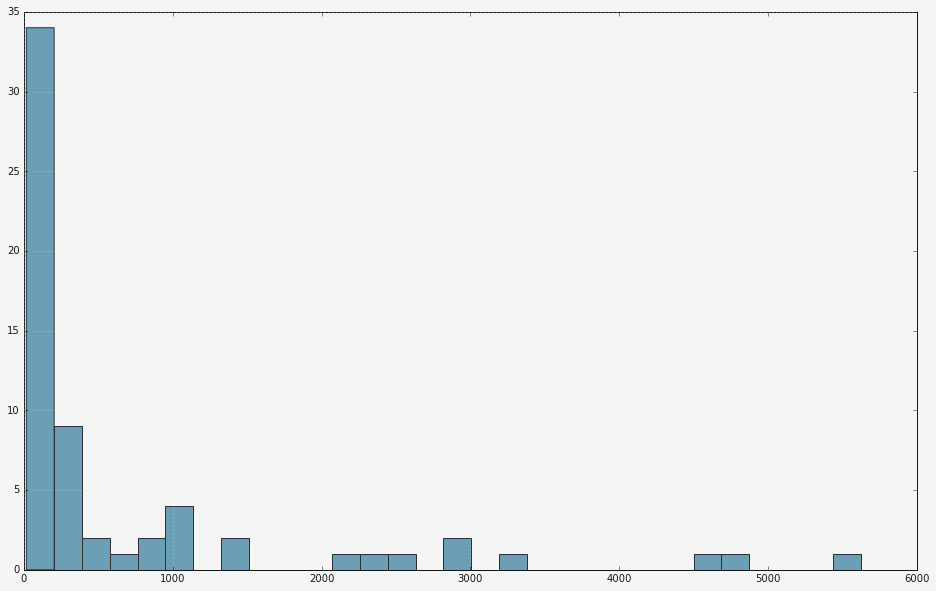

In [325]:
_ = results_df['worker_id'].value_counts().hist(bins= 30)

# HIT end-of-life

## Pickle Results for temp storage

In [246]:
temp_store_dir = './store_hit_results_metadata/group'
group_n = '_1_with_worker_id/'
try:
    os.mkdir(temp_store_dir + group_n)
except:
    OSError
    
result_file_name = 'hit_info.pkl'
assignment_file_name = 'assignment_info.pkl'
raw_results_file_name = 'raw_res.pkl'
complete_results_file = 'complete_df.pkl'
consensus_results_file = 'consensus_df.pkl'

amt_util.pickle_this(r_hits, temp_store_dir + group_n + result_file_name)
amt_util.pickle_this(assignment_results, temp_store_dir + group_n + assignment_file_name)
amt_util.pickle_this(raw_hit_results, temp_store_dir + group_n + raw_results_file_name)
results_df.to_pickle(temp_store_dir + group_n + complete_results_file)
consensus_results_df.to_pickle(temp_store_dir + group_n + consensus_results_file)

## Careful with these

In [225]:
# amt_util.accept_hits(mturk, assignment_results)

In [200]:
# amt_util.delete_all_hits(mturk)